In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import cv2 as cv

In [2]:
NUM_OF_FACES = 40
NUM_OF_IMAGES_PER_HUMAN_ENTRY = 10
FACES_PATH, FACES_TARGET_PATH = "pics/archive(1)/olivetti_faces.npy", "pics/archive(1)/olivetti_faces_target.npy"
MATRIX_SIZE = 64


faces = np.load(FACES_PATH)

face_to_classify = faces[0]

faces = faces[1:]

faces_target = np.load(FACES_TARGET_PATH)

faces.shape

(399, 64, 64)

In [3]:
faces_as_vectors = np.array([matrix.flatten() for matrix in faces])

faces_matrix_A = np.vstack(faces_as_vectors)
faces_matrix_A.shape

(399, 4096)

## Calculate the mean image

$$
\psi = \frac{1}{N} \sum \limits _{i = 1} ^ {N} Г_i
$$

In [4]:
mean_face_vector = np.mean(faces_as_vectors, axis=0)
mean_face_vector.shape

(4096,)

## Plot the mean dataset image

In [5]:
mean_image = np.array([np.array(mean_face_vector[MATRIX_SIZE * i : MATRIX_SIZE * (i + 1)]) for i in range(MATRIX_SIZE)])

print(mean_image)

# cv.imshow("Mean dataset image", mean_image)

# cv.waitKey(0)

# cv.destroyAllWindows()

[[0.40036047 0.43440205 0.47642857 ... 0.41379282 0.37866333 0.34561616]
 [0.40652263 0.44525594 0.48751006 ... 0.42080405 0.38419405 0.34960338]
 [0.4129124  0.45504245 0.4953189  ... 0.42846772 0.38955835 0.3519542 ]
 ...
 [0.34170154 0.3544814  0.35588995 ... 0.31311768 0.31157443 0.30304074]
 [0.35432586 0.36317047 0.36426803 ... 0.31523013 0.31203026 0.30945134]
 [0.36086094 0.3671884  0.3714864  ... 0.32183772 0.3140291  0.31083918]]


## Compute covarience matrix

$$
R = A^T A
$$

In [6]:
normed_faces = faces_matrix_A - mean_face_vector

covariance_matrix = np.cov(normed_faces.transpose())
covariance_matrix.shape


(4096, 4096)

## Compute SVD 
$$
R = U \lambda V^T
$$

Where U has eigenvectors and L is a diagonal matrix with eigenvalues as its entries


In [7]:
U, L, V_T = np.linalg.svd(covariance_matrix)

U.shape

(4096, 4096)

## Plot the eigenfaces

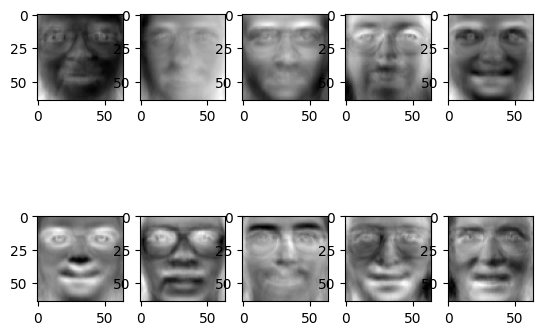

In [8]:
NUM_OF_EIGENFACES_TO_PLOT = 10
for i in range(NUM_OF_EIGENFACES_TO_PLOT):
    plt.subplot(2, 5, i + 1)
    eigenvectors = U[:, i].reshape(MATRIX_SIZE, MATRIX_SIZE)
    # plt.plot(U[:, i].reshape(MATRIX_SIZE, MATRIX_SIZE))
    plt.imshow(eigenvectors, cmap="gray")




## Reach the light invarience (Optional)

Norm every vector eigen vector. I do not do this, because it will lower the performance and the light invarience does not give much of a boost in classifing


## Take top eigenvectors from the dataset

Reach the dimensuality reduction via taking the eigenvectors, that contribute the most to the classification

N - number of dimensions of U

T - threshold of dataset coverage

$$
\frac{\sum \limits _{i = 1} ^ {k} \lambda_i} {\sum \limits _{j = 1} ^ {N} \lambda_j} \ge T
$$

In [9]:
sum_of_eigenvalues = sum(L)

confidence_level = 0.95
sum_k_eigenvalues, k = 0, 0

for num, i in enumerate(L):
    sum_k_eigenvalues += i
    if (sum_k_eigenvalues / sum_of_eigenvalues > confidence_level):
        k = num
        break

k


122

## Estimate the importance of eigenvectors for every image

$$
w_i = u_i^T (Г_i - \psi)
$$

In [10]:
weight_list = []

# print(normed_faces.shape)

for i in range(NUM_OF_FACES * NUM_OF_IMAGES_PER_HUMAN_ENTRY - 1):
    image_list = []
    for k_i in range(k):
        image_list.append(np.dot(U[k_i], normed_faces[i]))
    weight_list.append(np.array(image_list))



## Classify the face

$$
\hat{w_m} = \hat{u_m}^T (Г_{new} - \psi)
$$

$$
\Omega_{new} = [\hat{w_1}, \hat{w_2}, ... , \hat{w_k}]
$$

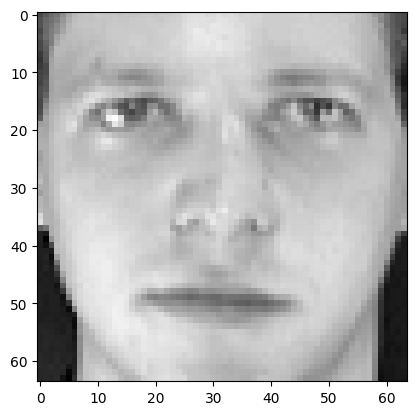

In [11]:
plt.imshow(face_to_classify, cmap='gray')

(-0.5, 63.5, 63.5, -0.5)

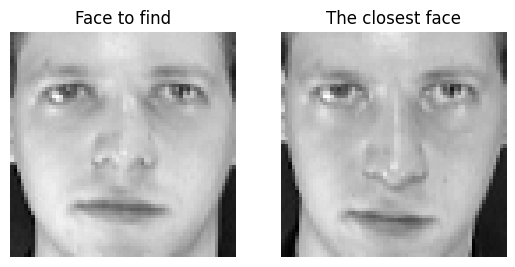

In [12]:
mean_substructed_face = face_to_classify.flatten() - mean_face_vector


weighted_prediction = []

for i in range(k):
    weighted_prediction.append(np.dot(mean_substructed_face, U[i]))

length_list = []
val_face_dist = float("inf")
ind = -1

for num, image in enumerate(weight_list):
    val = np.linalg.norm(np.array(weighted_prediction) - image)
    if (val_face_dist > val):
        val_face_dist = val
        ind = num
    # val_face_dist = min(val, val_face_dist)
    length_list.append(val)

length_list

# plt.title("Person recognition")
plt.subplot(1, 2, 1)
plt.title("Face to find")
plt.imshow(face_to_classify, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("The closest face")
plt.imshow(faces[ind], cmap='gray')
plt.axis('off')